In [81]:
import re
import ast
import nltk
import random
import numpy as np
import pandas as pd
from random import randint
from nltk import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
from sklearn.mixture import GaussianMixture
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Preprocessing

In [42]:
#loading dataset and removing unwanted features
dataset = pd.read_csv(f'Book_summary.csv', encoding= 'unicode_escape')
dataset = dataset.drop('Publication Date', axis=1)
dataset = dataset.drop('Wikibedia ID', axis=1)
dataset = dataset.drop('Freebase ID', axis=1)
dataset

,Book title,Book author,Genre,Summary
0,Animal Farm,George Orwell,"{""/m/016lj8"": ""Roman à clef"", ""/m/06nbt"": ""Sat...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,NaN,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...
16554,Under Wildwood,Colin Meloy,NaN,"Prue McKeel, having rescued her brother from ..."
16555,Transfer of Power,Vince Flynn,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,Decoded,Jay-Z,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,NaN,Colbert addresses topics including Wall Stree...


In [43]:
#check for nulls and removing nans
dataset.isnull().count()
dataset = dataset.dropna(axis = 0)
dataset = dataset.reset_index(drop=True)
dataset

,Book title,Book author,Genre,Summary
0,Animal Farm,George Orwell,"{""/m/016lj8"": ""Roman à clef"", ""/m/06nbt"": ""Sat...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,A Fire Upon the Deep,Vernor Vinge,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
4,All Quiet on the Western Front,Erich Maria Remarque,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul B??umer, a G..."
...,...,...,...,...
12050,The Third Lynx,Timothy Zahn,"{""/m/06n90"": ""Science Fiction""}",The story starts with former government agent...
12051,Remote Control,Andy McNab,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction...",The series follows the character of Nick Ston...
12052,Transfer of Power,Vince Flynn,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
12053,Decoded,Jay-Z,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...


In [71]:
def cleaned_text(raw_text):
    raw_text = re.findall(r"[a-zA-Z]+", raw_text)
    raw_text = " ".join(raw_text).lower()
    tokens = word_tokenize(raw_text)
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens

In [14]:
def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

In [103]:
cleaned_dataset = dataset.copy()
cleaned_dataset.insert(loc=3, column='Book summary', value="")
unique_genres = {}

for index, row in cleaned_dataset.iterrows():
    row["Genre"] = list(ast.literal_eval(row["Genre"]).values())
    for item in row["Genre"]:
        if item not in unique_genres:
            unique_genres[item] = 1
        else:
            unique_genres[item] += 1
            
    tokens = cleaned_text(str(row['Summary']))
    # Convert list of strings to string
    row['Book summary'] = convert_list_to_string(tokens)

for index, row in cleaned_dataset.iterrows():
    if len(row["Genre"]) == 1:
        row["Genre"] = row["Genre"][0]
    else :
        max_ = 0
        pop_genre = ""
        for item in row["Genre"]:
            if unique_genres[item] > max_:
                max_ = unique_genres[item]
                pop_genre = item
        row["Genre"] = pop_genre

cleaned_dataset = pd.DataFrame(cleaned_dataset)
cleaned_dataset.drop('Summary', axis=1)

,Book title,Book author,Genre,Book summary
0,Animal Farm,George Orwell,Fiction,old major old boar manor farm call animal farm...
1,A Clockwork Orange,Anthony Burgess,Fiction,alex teenager living near future england lead ...
2,The Plague,Albert Camus,Fiction,text plague divided five part town oran thousa...
3,A Fire Upon the Deep,Vernor Vinge,Fiction,novel posit space around milky way divided con...
4,All Quiet on the Western Front,Erich Maria Remarque,War novel,book tell story paul b umer german soldier urg...
...,...,...,...,...
12050,The Third Lynx,Timothy Zahn,Science Fiction,story start former government agent frank comp...
12051,Remote Control,Andy McNab,Fiction,series follows character nick stone ex militar...
12052,Transfer of Power,Vince Flynn,Fiction,reader first meet rapp covert operation iran d...
12053,Decoded,Jay-Z,Autobiography,book follows rough chronological order switchi...


In [129]:
cleaned_dataset.groupby(["Genre"]).count()

,Book title,Book author,Book summary,Summary
Genre,,,,
Absurdist fiction,2,2,2,2
Adventure novel,56,56,56,56
Albino bias,1,1,1,1
Alien invasion,1,1,1,1
Alternate history,17,17,17,17
...,...,...,...,...
War novel,26,26,26,26
Western,9,9,9,9
Western fiction,8,8,8,8


# Feature Engineering

## TF-IDF

In [387]:
tfIdf_vectorizer = TfidfVectorizer(use_idf=True, min_df=0.05)

tfidf_model = tfIdf_vectorizer.fit_transform(cleaned_dataset['Book summary'])
tfidf_features = pd.DataFrame(tfidf_model.toarray(), columns = tfIdf_vectorizer.get_feature_names())

D:\Hagar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [388]:
tfidf_features

,ability,able,accident,across,act,action,actually,adventure,affair,age,...,work,working,world,would,written,year,yet,york,young,younger
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.016108,0.062023,0.014802,0.000000,0.0,0.012618,0.000000,0.0,0.030525,0.0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.058797,0.00000,0.0,0.0,...,0.000000,0.056115,0.000000,0.000000,0.0,0.068494,0.000000,0.0,0.082851,0.0
2,0.000000,0.000000,0.0,0.000000,0.045781,0.045051,0.000000,0.00000,0.0,0.0,...,0.032764,0.042053,0.000000,0.066288,0.0,0.000000,0.045515,0.0,0.031044,0.0
3,0.056044,0.000000,0.0,0.000000,0.052866,0.000000,0.101763,0.00000,0.0,0.0,...,0.000000,0.000000,0.139067,0.000000,0.0,0.088910,0.000000,0.0,0.035849,0.0
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.12049,0.0,0.0,...,0.000000,0.000000,0.149440,0.000000,0.0,0.000000,0.056480,0.0,0.038523,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12050,0.000000,0.142992,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.115878,0.0
12051,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.356158,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
12052,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
12053,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.088724,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


## Doc2Vec

In [272]:
documents = [doc for doc in cleaned_dataset["Book summary"]]
tagged_documents = [TaggedDocument(tokens, [i]) for i, tokens in enumerate(documents)]

doc2vec_model = Doc2Vec(vector_size=300, min_count=2, epochs=40)
doc2vec_model.build_vocab(tagged_documents)
doc2vec_model.train(tagged_documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

doc2vec_features = [doc2vec_model.infer_vector(doc.split()) for doc in documents]
doc2vec_features = np.array(doc2vec_features)

In [273]:
doc2vec_features = pd.DataFrame(doc2vec_features)
doc2vec_features

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-2.760529e-04,-0.000279,-0.000691,0.001594,0.001329,0.000764,-0.001537,0.000567,0.000446,0.001345,...,0.000839,0.000607,0.000811,0.001633,-0.001376,-0.000302,-0.000696,-0.001331,0.000518,0.001025
1,-1.025029e-03,-0.092955,0.007227,-0.087513,-0.064305,-0.036309,-0.026836,0.028222,0.013790,0.014406,...,0.021566,0.001325,0.037199,0.101925,-0.000388,-0.114724,0.041496,0.079945,-0.002874,0.013663
2,2.708028e-04,0.000450,0.000725,0.001254,0.000344,-0.000602,0.000411,-0.000259,-0.001086,0.000116,...,-0.001450,-0.001547,-0.000062,0.001568,-0.001270,-0.000438,-0.000074,0.001435,-0.001289,0.000103
3,2.404054e-07,0.001458,-0.000802,0.000815,0.001478,-0.000798,-0.000749,-0.001050,-0.001469,-0.000376,...,-0.000548,-0.001551,0.000347,-0.000905,-0.000554,-0.000313,0.001586,-0.000181,-0.000076,-0.000138
4,1.995504e-02,-0.049800,-0.119269,0.013692,0.043662,-0.004642,0.041860,-0.044832,0.090245,0.081784,...,-0.058037,-0.028593,-0.008365,0.146433,-0.110008,-0.088177,0.094434,0.138446,0.003648,-0.139631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12050,-2.805830e-04,-0.000339,0.001100,-0.000025,-0.000352,0.000058,0.001317,0.001464,0.001210,0.000635,...,-0.001654,-0.001158,-0.001607,-0.000923,-0.000105,0.001158,0.000803,-0.000965,-0.000037,0.001539
12051,1.606959e-03,-0.001650,-0.001412,-0.000768,-0.000144,-0.001066,0.001597,-0.001321,0.000540,0.001049,...,0.000583,0.000565,-0.001630,0.000294,-0.000391,-0.000236,-0.001612,0.001483,-0.000330,0.000538
12052,5.422515e-03,-0.018708,0.020290,0.031034,0.027860,0.002083,-0.002497,-0.015750,0.025900,0.000391,...,-0.002631,-0.011788,0.019219,0.085244,-0.002998,-0.104143,0.031122,0.035613,-0.015783,-0.055016
12053,3.778249e-02,-0.068777,0.099188,-0.110365,-0.057274,-0.091403,-0.270756,-0.074195,0.110681,-0.178912,...,-0.064597,-0.091934,0.121459,0.453714,-0.033425,-0.689019,0.294966,0.258248,-0.093461,-0.341879


## TF-IDF + Doc2Vec

In [389]:
tfidf_doc2vec_features = pd.concat([tfidf_features, doc2vec_features], axis=1)

# Clustering

In [293]:
import matplotlib.cm as cm
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import KElbowVisualizer

In [276]:
model = KMeans(n_clusters = 30).fit_predict(doc2vec_features)

In [390]:
model2 = DBSCAN(eps=0.1, min_samples=3, metric="cosine").fit_predict(tfidf_doc2vec_features)

D:\Hagar\anaconda3\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [391]:
np.unique(model2)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=int64)

In [392]:
indices = doc2vec_features[model2 == 0].index

In [393]:
indices

Int64Index([19, 1004, 1601, 10196, 10833], dtype='int64')

In [394]:
cosine_scores = []
for ind, val in enumerate(indices):
    cosine_score = cosine(doc2vec_features[model2 == 0].iloc[0], doc2vec_features[model2 == 0].iloc[ind])
    cosine_scores.append(cosine_score)
    
print(cosine_scores)

[0.0, 0.006189227104187012, 0.009206533432006836, 0.002253413200378418, 0.005360603332519531]


In [395]:
np.argpartition(cosine_scores, 4)[:4]

array([0, 1, 4, 3], dtype=int64)

In [396]:
ya = doc2vec_features[model2 == 0].iloc[np.argpartition(cosine_scores, 4)[:4]].index

In [351]:
ya

Int64Index([1, 2669, 7194, 9354], dtype='int64')

In [397]:
cleaned_dataset.iloc[ya]

,Book title,Book author,Genre,Book summary,Summary
19,The Trial,Franz Kafka,Fiction,thirtieth birthday chief financial officer ban...,"On his thirtieth birthday, the chief financia..."
1004,The Castle,Franz Kafka,Fiction,narrator k arrives village governed mysterious...,"The narrator, K., arrives in a village govern..."
10833,March to the Sea,John Ringo,Science Fiction,event marshad end previous book roger marine m...,After the events in Marshad (at the end of th...
10196,The Last Egyptian,L. Frank Baum,Adventure novel,extensive diacritical mark appear novel publis...,The extensive diacritical marks appear in the...


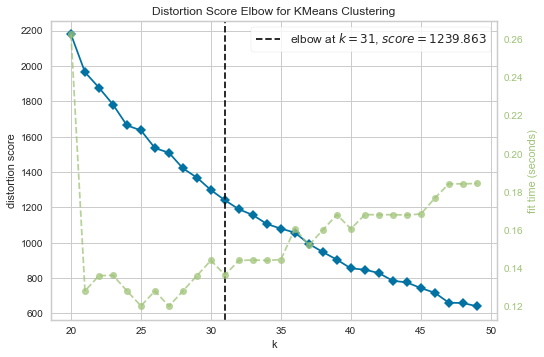

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [137]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(20,50))

visualizer.fit(tfidf_features_reduced)        # Fit the data to the visualizer
visualizer.show()  